# 1dResNet-style CNN + BiLSTM

## Preliminaries

### Connect to Drive

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/AN2DL/Homework2

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive/AN2DL/Homework2


### Import Libraries

In [ ]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print("TensorFlow version: ", tf.__version__)

from tensorflow.keras import mixed_precision

# Import other libraries
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler

TensorFlow version:  2.15.0


##### TPU connection

In [ ]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
    print("Device:", tpu.master())
    strategy = tf.distribute.TPUStrategy(tpu)

    # policy = mixed_precision.Policy('mixed_float16')

except ValueError:
    print("Not connected to a TPU runtime. Using CPU/GPU strategy")
    strategy = tf.distribute.MirroredStrategy()
    strategy = None
    policy = mixed_precision.Policy('mixed_float16')

    # Import the mixed precision according to the strategy
    mixed_precision.set_global_policy(policy)

    print('Compute dtype: %s' % policy.compute_dtype)
    print('Variable dtype: %s' % policy.variable_dtype)

Not connected to a TPU runtime. Using CPU/GPU strategy
Compute dtype: float16
Variable dtype: float32


##### Define base paths

In [ ]:
base_path = 'networks/'
submission_file ='ToySubmission/'

### Import data

#### unzip data

In [ ]:
unzip = False
if unzip:
    !unzip data/training_dataset.zip

In [ ]:
delete = False
if delete:
  !rm data/categories.npy, data/training_data.npy, data/valid_periods.npy # Delete the unzipped dataset

#### Load the dataset

In [ ]:
categories = np.load('data/categories.npy', allow_pickle=True)
valid_periods = np.load('data/valid_periods.npy', allow_pickle=True)
data = np.load('data/training_data.npy', allow_pickle=True)#.astype('float32')

#### Categories

In [ ]:
balance = True
if balance is True:
    balanced_index = []
    for i in np.unique(categories):

        indices_category = [index for index, category in enumerate(categories) if category == i]

        top_values_indices_category = sorted(indices_category, key=lambda idx: valid_periods[idx,0])[:277]

        for j in top_values_indices_category:
          balanced_index.append(j)
        del indices_category
        del top_values_indices_category
    #len(balanced_index)

    data=data[balanced_index,:]
    categories=categories[balanced_index]
else:
    long_ts = np.where(np.any(valid_periods < 2470, axis=1))[0]
    data=data[long_ts]
    categories=categories[long_ts]

#### Robust Scaling

In [ ]:
robust = False
print(data.shape)

# Find the index of the first non-zero element along the time axis (axis=1)
non_zero_indices = np.argmax(data != 0, axis=1)

# Extract the relevant portion of the time series data
data_trimmed = np.array([data[i, index:] for i, index in enumerate(non_zero_indices)])
print(data_trimmed.shape)
# Flatten the array to a 2D array
flattened_data = np.concatenate(data_trimmed)
print(flattened_data.shape)

# Remove NaN values from flattened_data
flattened_data_without_nan = flattened_data[~np.isnan(flattened_data)]

print("Flattened data without NaN:")
print(flattened_data_without_nan.shape)

# Compute the median of the flattened array
Q1 = np.percentile(flattened_data_without_nan, 25, axis=0)
Q3 = np.percentile(flattened_data_without_nan, 75, axis=0)
IQR = Q3 - Q1
normalized_data = (data_trimmed - Q1) / IQR
print(normalized_data.shape)

# Add zero-padding back to the beginning of each time series
padded_data_again = []

for i, index in enumerate(non_zero_indices):
    # Find the length of the removed portion (zero-padding)
    padding_length = index
    # Add zero-padding back to the beginning of each time series
    padded_row = np.pad(normalized_data[i], (padding_length, 0), 'constant', constant_values=(0, 0))
    padded_data_again.append(padded_row)

if robust is True:
  data = np.array(padded_data_again)
print("Padded data again shape:")
print(data.shape)

(1662, 2776)
(1662,)
(906372,)
Flattened data without NaN:
(906372,)
(1662,)
Padded data again shape:
(1662, 2776)


#### Build Sequences

In [ ]:
data.shape, data.dtype

((1662, 2776), dtype('float64'))

In [ ]:
def build_sequences(df, window=200, stride=20, telescope=18):
    # Sanity check to avoid runtime errors
    assert window % stride == 0
    dataset = []
    labels = []
    temp_df = df.copy()
    # temp_label = df.copy()
    padding_check = df.shape[1]%window

    if(padding_check != 0):
        # Compute padding length
        padding_len = window - df.shape[1]%window
        padding = np.zeros((temp_df.shape[0],padding_len), dtype='float32')
        temp_df = np.concatenate((padding,temp_df),axis=-1)

        assert temp_df.shape[1] % window == 0

    for temp_row in temp_df:
        for idx in np.arange(0,len(temp_row)-window-telescope,stride):
            dataset.append(temp_row[idx:idx+window])
            labels.append(temp_row[idx+window:idx+window+telescope])

    dataset = np.array(dataset)
    labels = np.array(labels)
    return dataset, labels

In [ ]:
window, stride, telescope = 200, 20, 18

X_train, y_train = build_sequences(data, window, stride, telescope)

# X_train, y_train = data[:,:-18], data[:,-18:]

X_train = np.expand_dims(X_train, axis=-1)

print(X_train.shape, y_train.shape)

# Find indices where at least one value in each row is greater than zero
non_zero_rows_indices = np.where(np.any(X_train > 0, axis=(1)))[0]

# Filter X_train based on non-zero rows
X_train = X_train[non_zero_rows_indices]
y_train = y_train[non_zero_rows_indices]
print(X_train.shape, y_train.shape)

(216060, 200, 1) (216060, 18)
(44417, 200, 1) (44417, 18)


In [ ]:
input_shape = X_train.shape[1:]
output_shape = y_train.shape[-1]

input_shape, output_shape

((200, 1), 18)

### Define 1D ResNet-style CNN

In [ ]:
def conv_residual_block(x, filters=64, kernel_size=3, padding='same', downsample=False, stack=2, batch_norm=True, name=''):

    # If downsample is True, apply max-pooling
    if downsample:
        x = tfkl.MaxPooling1D(name='MaxPool_' + name)(x)

    # Create a copy of the input for the residual connection
    x_ = x


    # Apply a stack of convolutional layers to the copy
    for s in range(stack):
        x_ = tfkl.Conv1D(filters=filters, kernel_size=kernel_size, padding=padding, name='Conv_' + name + str(s+1))(x_)
        if batch_norm:
            x_ = tfkl.BatchNormalization(name='BatchNorm_' + name + str(s+1))(x_)
        x_ = tfkl.LeakyReLU(name='Activation_' + name + str(s+1))(x_)

    # If downsample is True, apply a 1x1 convolution to match the number of filters
    if downsample:
        x = tfkl.Conv1D(filters=filters, kernel_size=1, padding=padding, name='Conv_' + name + 'skip')(x)

    # Add the original and the processed copy to create the residual connection
    x = tfkl.Add(name='Add_' + name)([x_, x])

    return x

In [ ]:
def decoder_residual_block(x, filters=64, kernel_size=3, padding='same', strides=1, downsample=False, stack=2, batch_norm=True, name=''):

    # Create a copy of the input for the residual connection
    x_ = x

    for s in range(stack):
        x_ = tfkl.Conv1D(filters=filters/(s+1), kernel_size=kernel_size, padding=padding, strides=strides, name='Conv_' + name + str(s+1), use_bias=False)(x_)
        if batch_norm:
            x_ = tfkl.BatchNormalization()(x_)
        x_ = tfkl.LeakyReLU()(x_)
        #x_ = tfkl.MaxPooling1D(name='MaxPool_' + name + str(s+1))(x_)

    x = tfkl.Conv1D(filters=filters/2, kernel_size=1, padding=padding, name='Conv_' + name + 'skip')(x)

    # Add the original and the processed copy to create the residual connection
    x = tfkl.Add(name='Add_' + name)([x_, x])

    return x

In [ ]:
def build_model(input_shape, output_shape):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # Masking
    x = tfkl.Masking(mask_value=0.0, name='mask')(input_layer)

    x = conv_residual_block(x=x, filters=64, downsample=False, stack=2, name='1')
    x = conv_residual_block(x=x, filters=128, downsample=True, stack=2, name='2')
    x = conv_residual_block(x=x, filters=256, downsample=True, stack=2, name='3')
    x = conv_residual_block(x=x, filters=512, downsample=True, stack=2, name='4')

    # Add a Bidirectional LSTM layer
    #x = tfkl.Bidirectional(tfkl.LSTM(256, return_sequences=True, name='lstm'), name='bidirectional_lstm_1')(x)
    x = tfkl.Bidirectional(tfkl.LSTM(512, return_sequences=True, name='lstm'), name='bidirectional_lstm_2')(x)

    x = decoder_residual_block(x=x, filters=1024, downsample=True, stack=2, name='5')
    x = decoder_residual_block(x=x, filters=512, downsample=True, stack=2, name='6')
    x = decoder_residual_block(x=x, filters=256, downsample=True, stack=2, name='7')
    x = decoder_residual_block(x=x, filters=128, downsample=True, stack=2, name='8')
    x = decoder_residual_block(x=x, filters=64, downsample=True, stack=2, name='9')

    x = tfkl.Dropout(.2, seed=seed)(x)

    # Add a final Convolution layer to match the desired output shape
    x = tfkl.Conv1DTranspose(1, 3, padding='same',strides=2, use_bias=False, name='cnn_output_layer')(x)

    x = tfkl.Flatten()(x)

    output_layer = tfkl.Dense(output_shape, name='output_layer', use_bias=False)(x)

    # Construct the model by connecting input and output layers
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='1dResNet')

    # Compile the model with Mean Absolute Error loss and Adam optimizer
    model.compile(loss=tf.keras.losses.MeanAbsoluteError(), optimizer=tf.keras.optimizers.AdamW())
    # Return the model
    return model

Model: "1dResNet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Input (InputLayer)          [(None, 200, 1)]             0         []                            
                                                                                                  
 mask (Masking)              (None, 200, 1)               0         ['Input[0][0]']               
                                                                                                  
 Conv_11 (Conv1D)            (None, 200, 64)              256       ['mask[0][0]']                
                                                                                                  
 BatchNorm_11 (BatchNormali  (None, 200, 64)              256       ['Conv_11[0][0]']             
 zation)                                                                                   

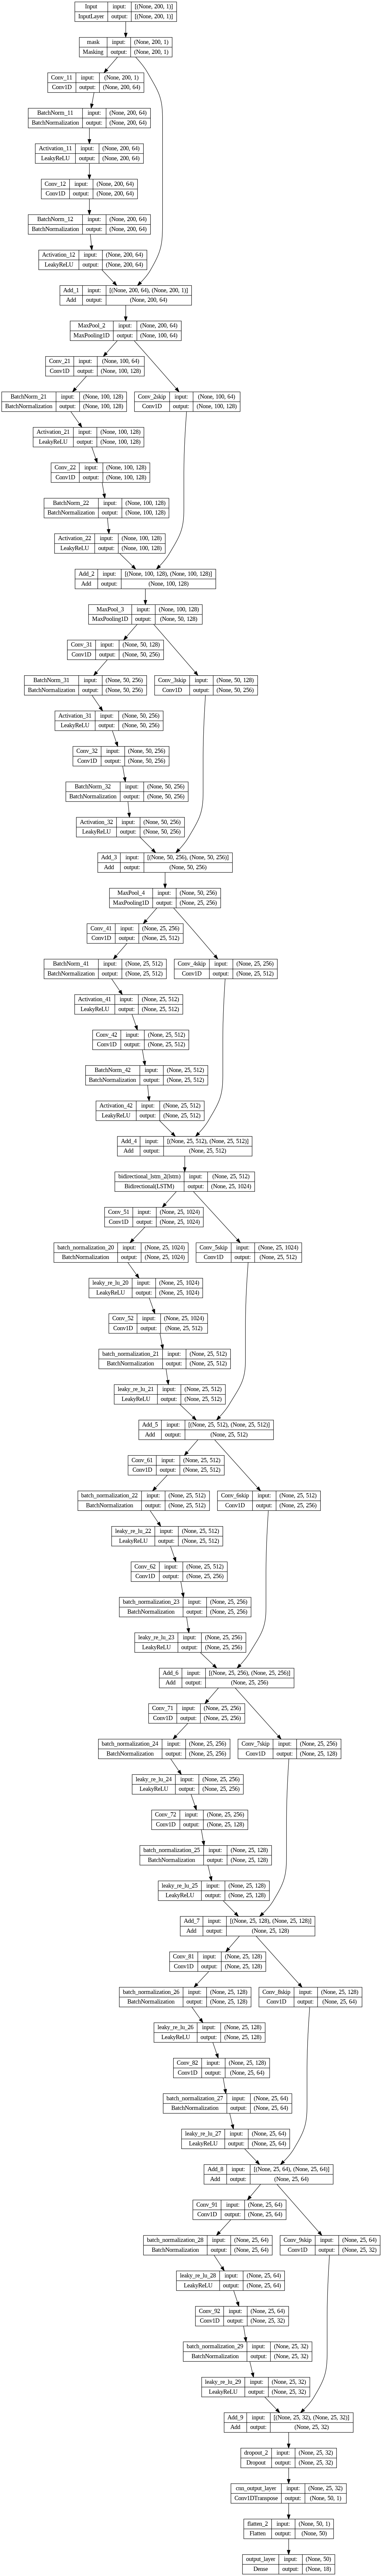

In [ ]:
if strategy != None:
    with strategy.scope():
      model = build_model(input_shape, output_shape)
else:
      model = build_model(input_shape, output_shape)
model.summary()
tfk.utils.plot_model(model, expand_nested=True, show_shapes=True)

In [ ]:
batch_size = 200
epochs = 800

# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.39,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=23, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=10, factor=0.1, min_lr=5e-6)
    ]
).history

Epoch 1/800
184/184 [==============================] - 94s 153ms/step - loss: 0.4125 - val_loss: 0.2217 - lr: 0.0010
Epoch 2/800
184/184 [==============================] - 14s 76ms/step - loss: 0.1001 - val_loss: 0.2079 - lr: 0.0010
Epoch 3/800
184/184 [==============================] - 14s 74ms/step - loss: 0.0806 - val_loss: 0.1203 - lr: 0.0010
Epoch 4/800
184/184 [==============================] - 13s 73ms/step - loss: 0.0741 - val_loss: 0.0612 - lr: 0.0010
Epoch 5/800
184/184 [==============================] - 17s 93ms/step - loss: 0.0701 - val_loss: 0.0637 - lr: 0.0010
Epoch 6/800
184/184 [==============================] - 13s 73ms/step - loss: 0.0685 - val_loss: 0.0569 - lr: 0.0010
Epoch 7/800
184/184 [==============================] - 13s 73ms/step - loss: 0.0651 - val_loss: 0.0581 - lr: 0.0010
Epoch 8/800
184/184 [==============================] - 13s 73ms/step - loss: 0.0612 - val_loss: 0.0571 - lr: 0.0010
Epoch 9/800
184/184 [==============================] - 13s 73ms/step - 

In [ ]:
0.05030623823404312

In [ ]:
0.04693157970905304

0.049650225788354874


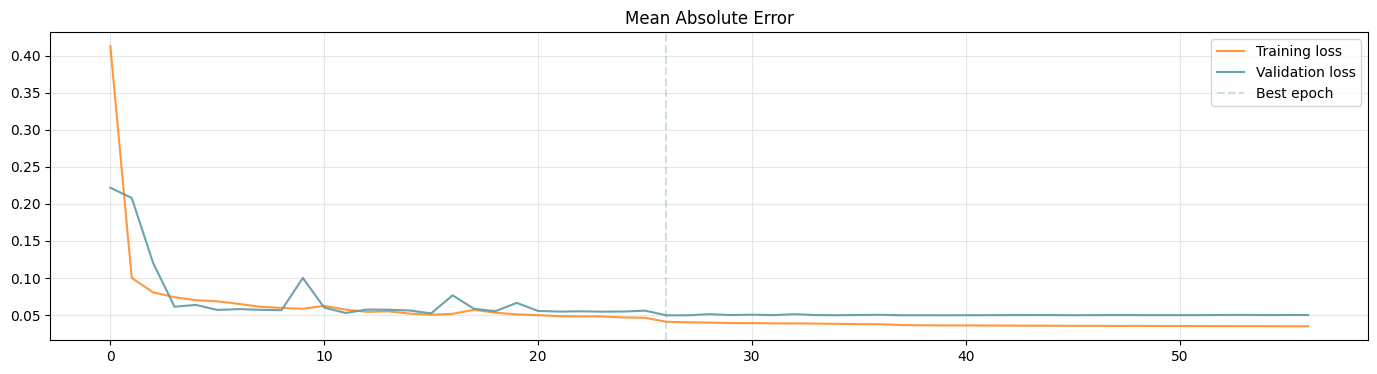

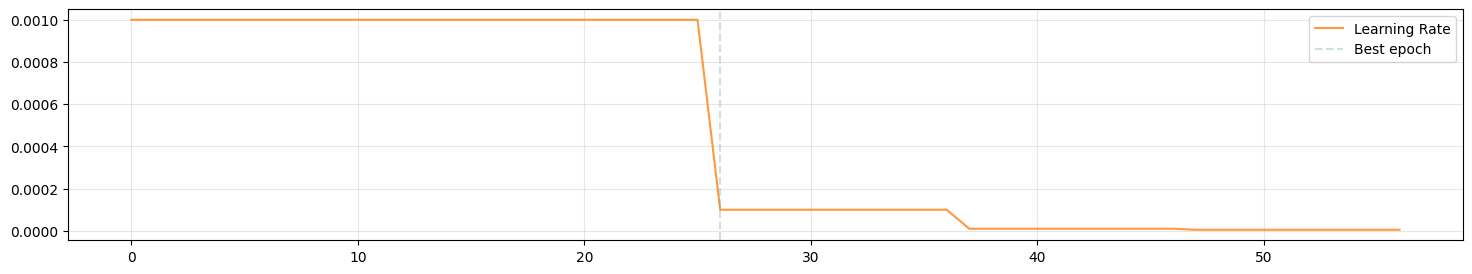

In [ ]:
print(np.min(history['val_loss']))

best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Absolute Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [ ]:
model_name = '1dResNet-deepLSTMCNN_tele18_33val'

In [ ]:
saved_model_filepath = base_path + model_name

submission_model_filepath = submission_file + 'SubmissionModel'

In [ ]:
model.save(submission_model_filepath)

In [ ]:
# Export trained model
model.save(saved_model_filepath)

#### Make inference - OPTIONAL

In [ ]:
%cd  /gdrive/My Drive/AN2DL/Homework2/ToySubmission
from model import model as model_py

# Predict, perform one-hot encoding and convert to a numpy array
predictions = model_py(os.getcwd()).predict(X_test)

%cd  /gdrive/My Drive/AN2DL/Homework2

# Print the shape of the predictions
print(f"Predictions shape: {predictions.shape}")

# Calculate and print Mean Squared Error (MSE)
mean_squared_error = tfk.metrics.mean_squared_error(y_test.flatten(), predictions.flatten()).numpy()
print(f"Mean Squared Error: {mean_squared_error}")

# Calculate and print Mean Absolute Error (MAE)
mean_absolute_error = tfk.metrics.mean_absolute_error(y_test.flatten(), predictions.flatten()).numpy()
print(f"Mean Absolute Error: {mean_absolute_error}")
#